<a href="https://colab.research.google.com/github/AminFathollahi/NMA_DL/blob/main/tutorials/W2D4_Macrolearning/student/W2D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Continual learning

**Week 2, Day 4: Macro-Learning**

**By Neuromatch Academy**

__Content creators:__ Hlib Solodzhuk, Ximeng Mao, Grace Lindsay

__Content reviewers:__ Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Hlib Solodzhuk, Ximeng Mao, Samuele Bolotta, Grace Lindsay, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Alex Murphy


___


# Tutorial Objectives

*Estimated timing of tutorial: 25 minutes*

In this tutorial, we wil discover how further training on new data or tasks causes forgetting of past tasks. This is like the idea of learning a new idea by replacing an old one. This is a huge issue with the current AI models and deep neural networks and a very active area of research in the ML community. We are going to explore the problem in more detail and investigate some further issues connected to this idea, for example, how different learning schedules impact performance.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "t36w8"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup



In [2]:
# @title Install and import feedback gadget

!pip install vibecheck datatops tqdm numpy matplotlib ipywidgets scikit-learn --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D4_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.3 MB/s eta 0:00:00


In [3]:
# @title Imports

# working with data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm

# interactive display
import ipywidgets as widgets

# modeling
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_summer_autumn_predictions(summer_predictions, autumn_predictions):
    """
    Plots the true data (summer and autumn prices) along with the predicted summer and autumn prices using a scatter plot.

    Inputs:
        - summer_predictions (numpy.ndarray): Array containing the predicted prices for the summer season.
        - autumn_predictions (numpy.ndarray): Array containing the predicted prices for the autumn season.
    """

    with plt.xkcd():
      plt.plot(np.append(summer_days, autumn_days), np.append(summer_prices, autumn_prices), label = "True Data")
      plt.scatter(autumn_days_test, autumn_predictions, label = "Autumn Predictions", marker='o', color='g', zorder=2)
      plt.scatter(summer_days_test, summer_predictions, label = "Summer Predictions", marker='o', color='r', zorder=2)
      plt.xlabel('Week')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

def plot_performance(num_epochs, summer_r_squared, autumn_r_squared):
    """
    Plots the R-squared values for the summer and autumn seasons during the training process.

    Inputs:
        - num_epochs (int): The number of training epochs.
        - summer_r_squared (list): List containing the R-squared values for the summer season at each epoch.
        - autumn_r_squared (list): List containing the R-squared values for the autumn season at each epoch.
    """

    print(f"Summmer final R-squared value is: {summer_r_squared[-1]:.02f}")
    print(f"Autumn final R-squared value is: {autumn_r_squared[-1]:.02f}")


    with plt.xkcd():
      plt.plot(np.arange(num_epochs), summer_r_squared, label = "Summer Fit")
      plt.plot(np.arange(num_epochs), autumn_r_squared, label = "Autumn Fit")
      plt.xlabel('Epoch')
      plt.ylabel('R-squared value')
      plt.legend()
      plt.show()

In [6]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)

set_seed(seed = 42)

In [7]:
# @title Video 1: Continual learning

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'owfKdX7UMn8'), ('Bilibili', 'BV1W4421Q79N')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [8]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_continual_learning")

---

# Section 1: Catastrophic Forgetting

In this section, we will discuss the concept of continual learning and argue that training on new data does not guarantee that the model will remember how to handle the tasks it was trained on earlier. First it's important to state that there are multiple ways to train some ML models. Often a model will take a training dataset and run a learning algorithm over it in a few steps and derive a solution resulting in a trained model. This is what happens in analytical solutions for linear regression, in Support Vector Machine training etc. In other cases, models can learn by being iteratively updated with single data points (or batches). This type of model can support **online learning** and it is specifically these models that have the potential to undergo catastrophic forgetting. Modern deep neural networks are all online learners, as are methods that are trained with variants of gradient descent. The problems of continual learning only exist for models that can be paused and then resumed with new training data, which has the potential to interact with a previous model that was also trained on prior data.

- Catastrophic forgetting occurs when a neural network, or any machine learning model, forgets the information it previously learned upon learning new data. This is particularly problematic in scenarios where a model needs to perform well across multiple types of data or tasks that evolve over time.

- Continual learning is an approach in machine learning that aims to mitigate the issues of catastrophic forgetting. The goal is to develop algorithms that can adapt to new data while preserving knowledge about the old data. This is essential for applications where the model must adapt to changes dynamically without losing the ability to perform tasks it was previously trained on.

## Coding Exercise 1: Fitting new data

We're back at the fruit stall. Recall the modelling problem from Tutorial 1. Let's assume now that we want our model to predict not only the summer prices but also the autumn ones. We have already trained the MLP to predict summer months effectively but observed that it performs poorly during the autumn period. Let's try to make the model learn new information about the prices and see whether it can remember both.

First, we will need to retrain the model for this tutorial on summer days.

In [9]:
#define variables
A = .005
B = 0.1
phi = 0
C = 1

#define days (observe that those are not 1, ..., 365 but proxy ones to make model function neat)
days = np.arange(-26, 26 + 1/7, 1/7)
prices = A * days**2 + B * np.sin(np.pi * days + phi) + C

#take only summer data for intro-training
summer_days = np.expand_dims(days[151:243], 1)
summer_prices = prices[151:243]

#take autumn data for further training
autumn_days = np.expand_dims(days[243:334], 1)
autumn_prices = prices[243:334]

#divide summer data into train and test sets
summer_days_train, summer_days_test, summer_prices_train, summer_prices_test = train_test_split(summer_days, summer_prices, random_state = 42)

#divide autumn data into train and test sets
autumn_days_train, autumn_days_test, autumn_prices_train, autumn_prices_test = train_test_split(autumn_days, autumn_prices, random_state = 42)

In [10]:
#apply normalization for days (we take parameters for whole summer-autumn period)
days_mean, days_std = np.mean(days[151:334]), np.std(days[151:334])

summer_days_train_norm = (summer_days_train - days_mean) / days_std
summer_days_test_norm = (summer_days_test - days_mean) / days_std

#notice that normalization is taken from summer parameters as obviously model is going to forget old data if we reassign it (by making normalization the same)
autumn_days_train_norm = (autumn_days_train - days_mean) / days_std
autumn_days_test_norm = (autumn_days_test - days_mean) / days_std

#define MLP
base_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state = 42, solver = "lbfgs") # LBFGS is better to use when there is small amount of data

#train MLP
base_model.fit(summer_days_train_norm, summer_prices_train)

#evaluate MLP on test data
print(f"R-squared value is: {base_model.score(summer_days_test_norm, summer_prices_test):.02f}.")

R-squared value is: 0.99.


Now, let's incrementally fit the autumn data to the trained model and monitor the R-squared values for the summer and autumn data test sets during each iteration. In the following code snippet, you are requested to complete further training using the `partial_fit` function, which allows us to train the existing model on new data (it runs through the data only once, and thus, we can control for the number of iterations). As we iterate through the epochs, we can append new R-squared values for each epoch. We will visually explore the performance of this model on both the summer and autumn datasets as well as R-squared values progression over epochs.

Training Progress: 100%|██████████| 9/9 [00:22<00:00,  2.54s/it]


Summmer final R-squared value is: -2231.12
Autumn final R-squared value is: 1.00


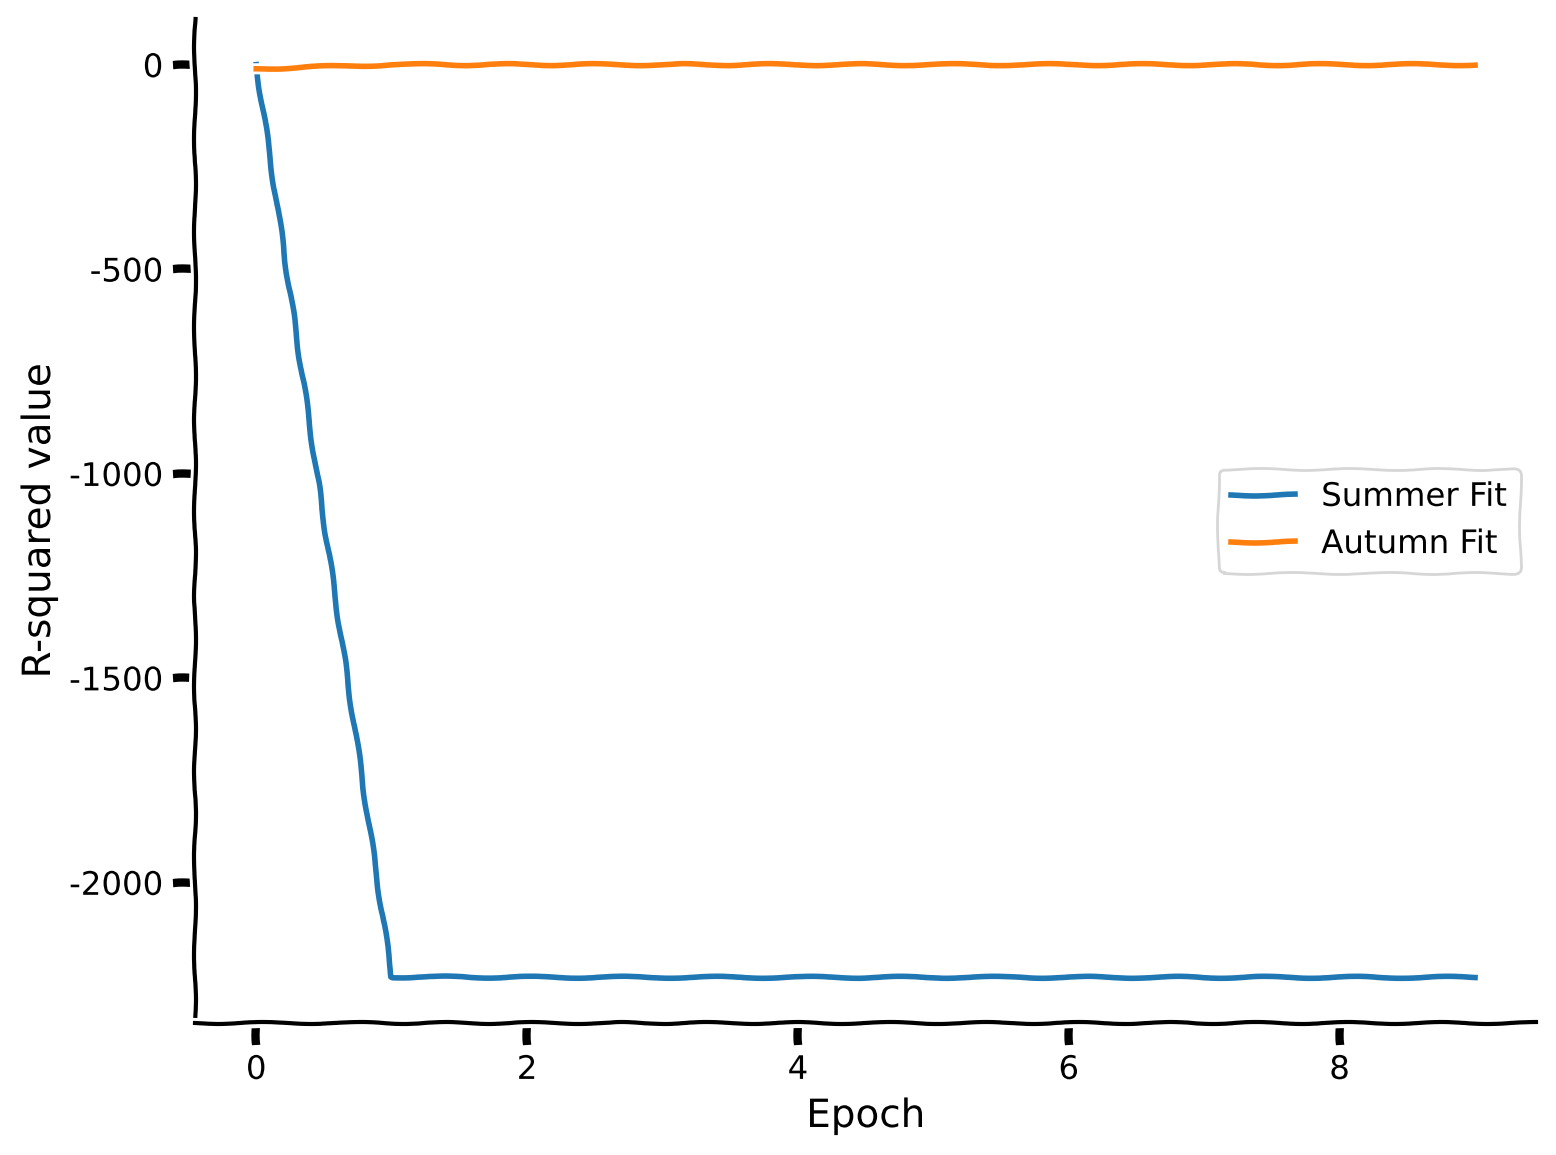

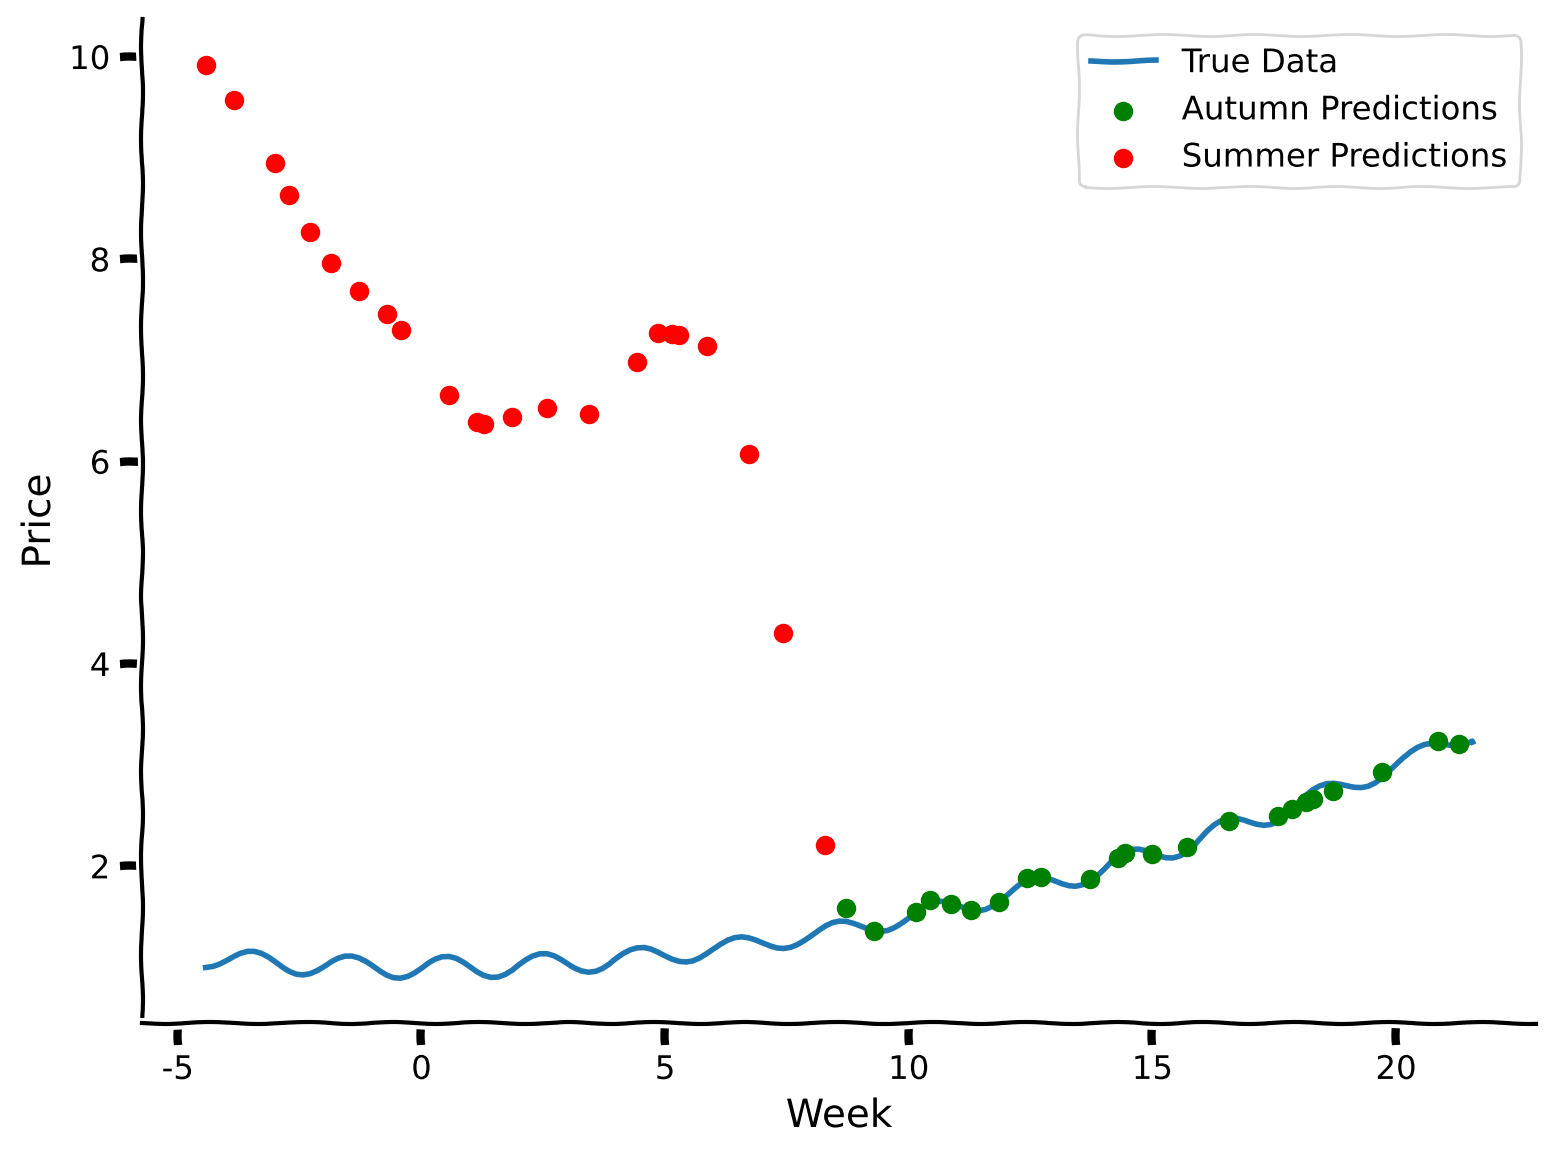

In [11]:
###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: complete partial fit and calculate r-squared values for both summer and autumn data")
###################################################################

# Initial r-squared calculations
summer_r_squared = [base_model.score(summer_days_test_norm, summer_prices_test)]
autumn_r_squared = [base_model.score(autumn_days_test_norm, autumn_prices_test)]
num_epochs = 10

# Progress bar integration with tqdm
for _ in tqdm(range(num_epochs - 1), desc="Training Progress"):

    # Fit new data for one epoch
    base_model.partial_fit(autumn_days_train_norm, autumn_prices_train)

    # Calculate r-squared values on test sets
    summer_r_squared.append(base_model.score(summer_days_train_norm, summer_prices_train))
    autumn_r_squared.append(base_model.score(autumn_days_train_norm, autumn_prices_train))

model = base_model
plot_performance(num_epochs, summer_r_squared, autumn_r_squared)

#predict for test sets
summer_prices_predictions = model.predict(summer_days_test_norm)
autumn_prices_predictions = model.predict(autumn_days_test_norm)

plot_summer_autumn_predictions(summer_prices_predictions, autumn_prices_predictions)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial2_Solution_c3936e0c.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial2_Solution_c3936e0c_7.png>

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial2_Solution_c3936e0c_8.png>



Notice how disruptive the change is for R-squared values — even one iteration is enough to drastically alter the performance. The model has learned to perform perfectly on the autumn data, while it completely messes up predictions for the summer days. Indeed, the model forgot the relationships for the old data and lost its predictive power while training on the new dataset. In the next section of the tutorial, we are going to explore a different approach—what if, instead of training sequentially, we train the model on both datasets together?

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_fitting_new_data")

---

# Section 2: Joint training

Estimated timing to here from start of tutorial: 10 minutes

In this section, we are going to explore whether joint training on both datasets simultaneously, specified in different formats, improves predictive performance, thus allowing the model to perform well in both summer and autumn.

## Coding Exercise 2a: Sequential joint training

In this coding exercise, let us take a look at the following setup: we will sample $K$ distinct random training examples from summer data and $K$ random examples from autumn, training the model in total on $2K$ examples.

In sequential joint training, epochs of each data type are alternated. So, for example, the first epoch will be the $K$ examples from summer data, and then the second will be the $K$ examples from autumn data, then the summer data again, then autumn again, and so on.

Please complete the partial fits for the corresponding data to implement sequential joint training in the coding exercise. We are using the `partial_fit` function to specify individual updates to the model. The `scikit-learn` library typically exposes a `fit` API whose goal is to specify full training on a dataset. However, if control over sequential training is desired, where you want to specify individual batches of data of a certain type, then models that expose a `partial_fit` function are great ways to accomplish this. In the language of training deep learning models, `fit` is similar to `train_model()` while `partial_fit` is more similar to `update_batch()`.

Every call to `partial_fit` takes the model from the previous call and continually updates the parameters from the previous step, in the same way that in deep neural networks, each batch update builds upon the adjusted network weights from the previous backpropagation step.

Training Progress: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Summmer final R-squared value is: 0.59
Autumn final R-squared value is: 0.99


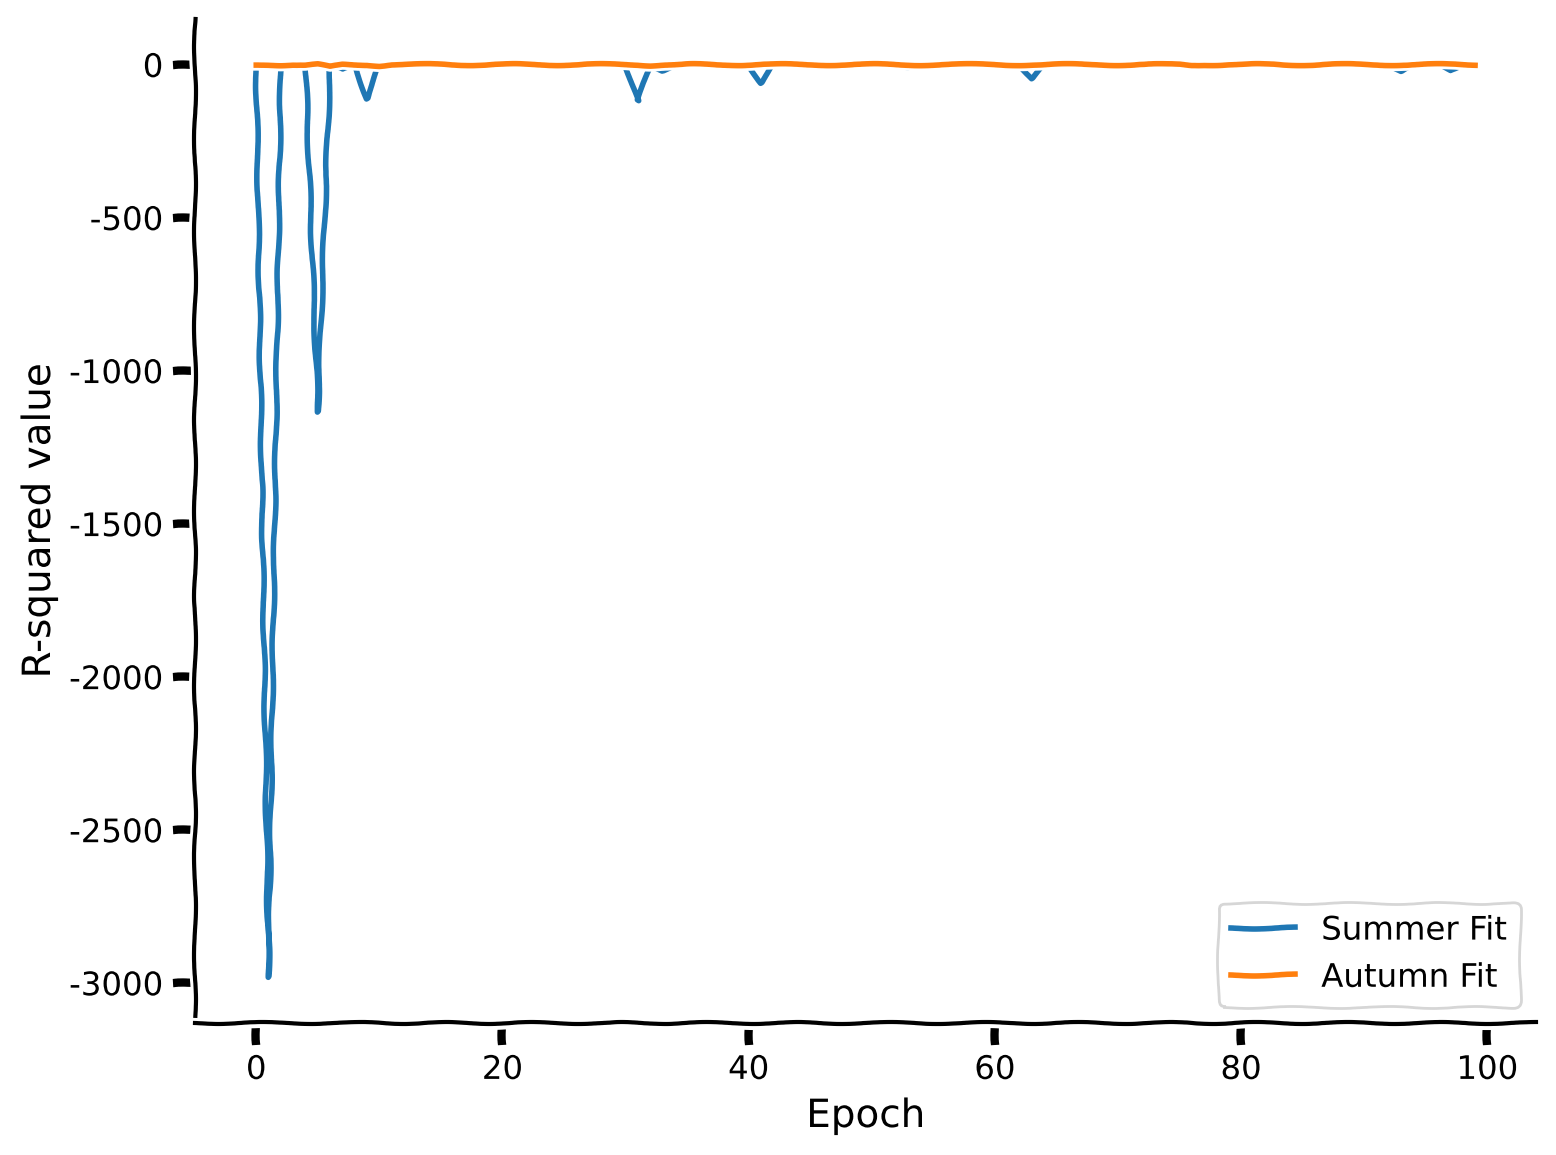

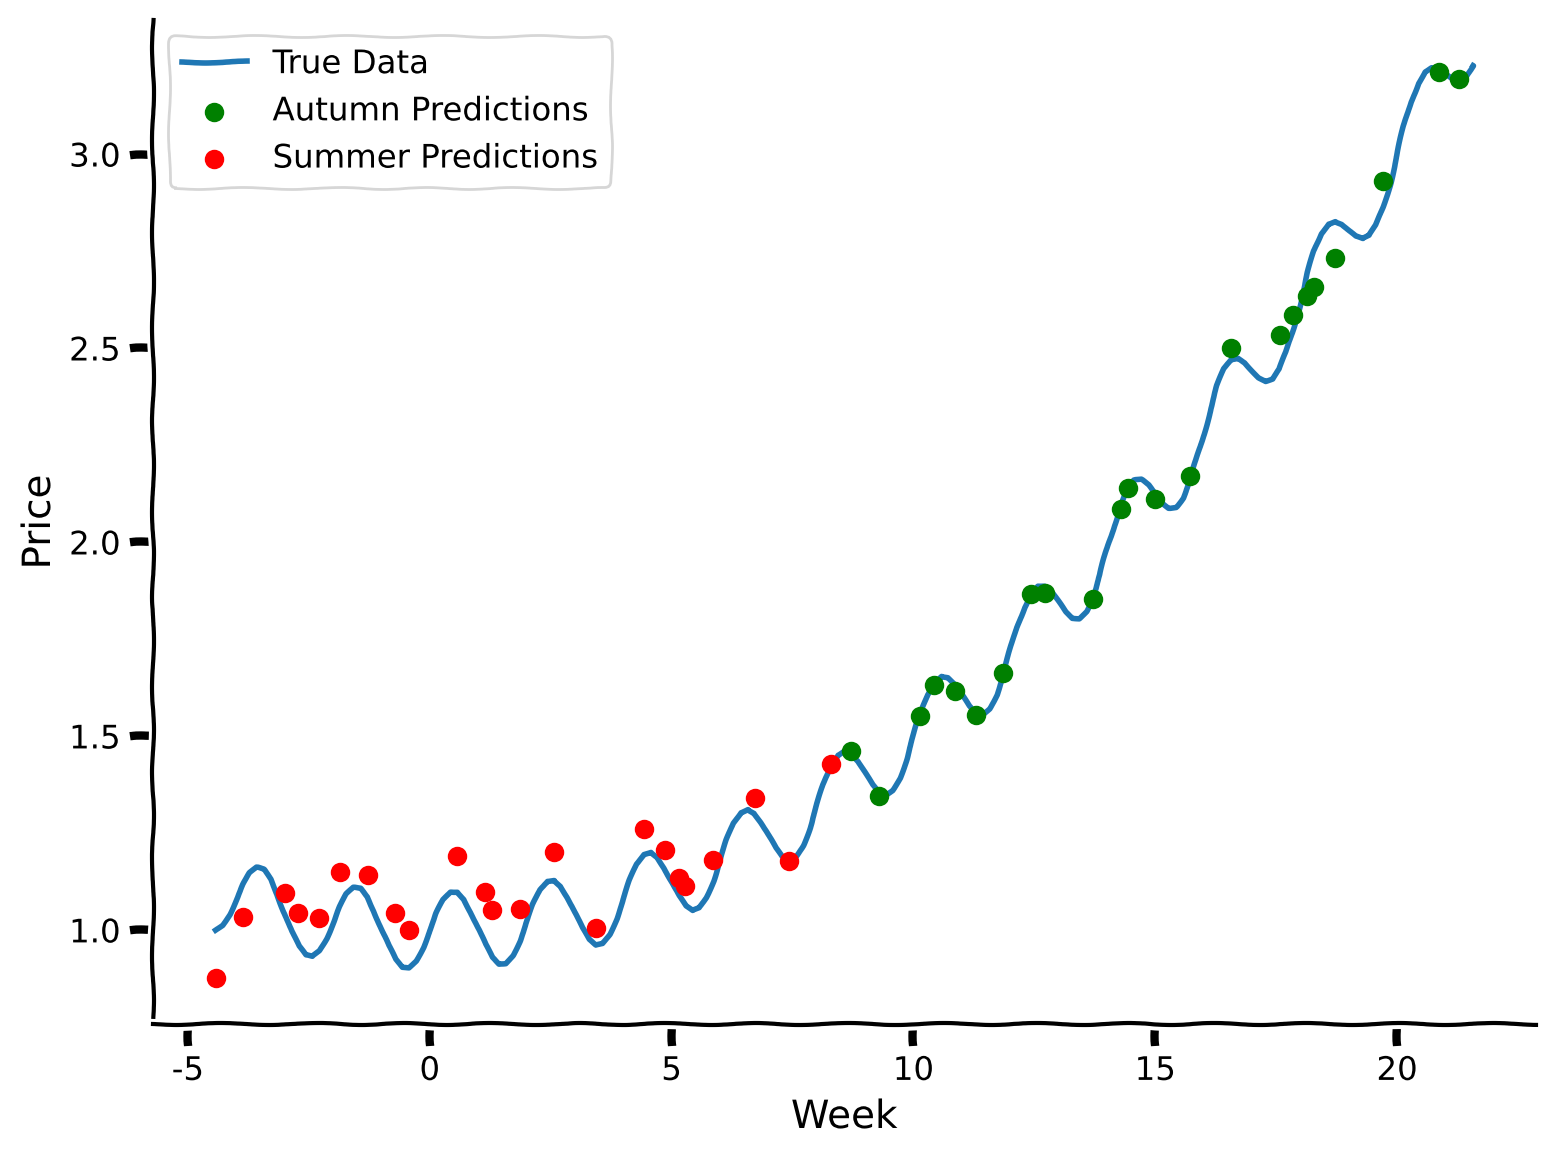

In [12]:
def sequential_training(K: int, num_epochs: int):
    """
    Perform sequential training for a multi-layer perceptron (MLP) regression model.
    The function trains the model separately on the summer and autumn data in alternating epochs.

    Inputs:
        - K (int): The number of training examples to sample from each season (summer and autumn) in each epoch.
        - num_epochs (int): The number of training epochs.

    Returns:
        - model (MLPRegressor): The trained MLP regression model.
        - summer_r_squared (list): A list containing the R-squared values for the summer season at each epoch.
        - autumn_r_squared (list): A list containing the R-squared values for the autumn season at each epoch.
    """

    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42, solver="lbfgs")
    summer_r_squared = []
    autumn_r_squared = []

    for _ in tqdm(range(num_epochs // 2), desc="Training Progress"):
        ###################################################################
        ## Fill out the following then remove
        # raise NotImplementedError("Student exercise: sample indices for summer and autumn data and sequentially train on summer and then on autumn data")
        ###################################################################

        # Sample random training examples from summer and autumn
        sampled_summer_indices = np.random.choice(np.arange(summer_days_train_norm.shape[0]), size=K, replace=False)
        sampled_autumn_indices = np.random.choice(np.arange(autumn_days_train_norm.shape[0]), size=K, replace=False)

        model.partial_fit(summer_days_train_norm[sampled_summer_indices], summer_prices_train[sampled_summer_indices])

        summer_r_squared.append(model.score(summer_days_test_norm, summer_prices_test))
        autumn_r_squared.append(model.score(autumn_days_test_norm, autumn_prices_test))

        model.partial_fit(autumn_days_train_norm[sampled_autumn_indices], autumn_prices_train[sampled_autumn_indices])

        summer_r_squared.append(model.score(summer_days_test_norm, summer_prices_test))
        autumn_r_squared.append(model.score(autumn_days_test_norm, autumn_prices_test))

    return model, summer_r_squared, autumn_r_squared

set_seed(42)
num_epochs = 100
K = 30

sequential_training_model, summer_r_squared, autumn_r_squared = sequential_training(K, num_epochs)

plot_performance(num_epochs, summer_r_squared, autumn_r_squared)

#predict for test sets
summer_prices_predictions = sequential_training_model.predict(summer_days_test_norm)
autumn_prices_predictions = sequential_training_model.predict(autumn_days_test_norm)

plot_summer_autumn_predictions(summer_prices_predictions, autumn_prices_predictions)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial2_Solution_e2bacfd6.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial2_Solution_e2bacfd6_54.png>

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial2_Solution_e2bacfd6_55.png>



As we can see, this approach performs better than first fully learning from the summer data and then learning from the autumn data. Sequential joint training helps maintain the model's performance across both datasets by continually refreshing its memory with information from both periods. This method prevents the model from completely forgetting the relationships learned from the first dataset while training on the second.

## Coding Exercise 2b: Interspersed training

Now, we will try fully interspersed training. Unlike sequential joint training, in this approach, we will generate epochs that contain both summer and autumn data, exposing the model to both sets equally and simultaneously.

In this exercise, you are tasked with completing the code snippets that correspond to creating the labels for the interspersed epochs and training the model. This method aims to integrate the data from both periods within each training epoch, which can help in achieving a more balanced and robust model performance across different seasonal datasets.

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Training Progress:   2%|▏         | 1/50 [00:44<36:14, 44.39s/it]/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Training Progress:   4%|▍         | 2/50 [00:48<16:23, 20.49s/it]/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

Summmer final R-squared value is: 0.97
Autumn final R-squared value is: 1.00


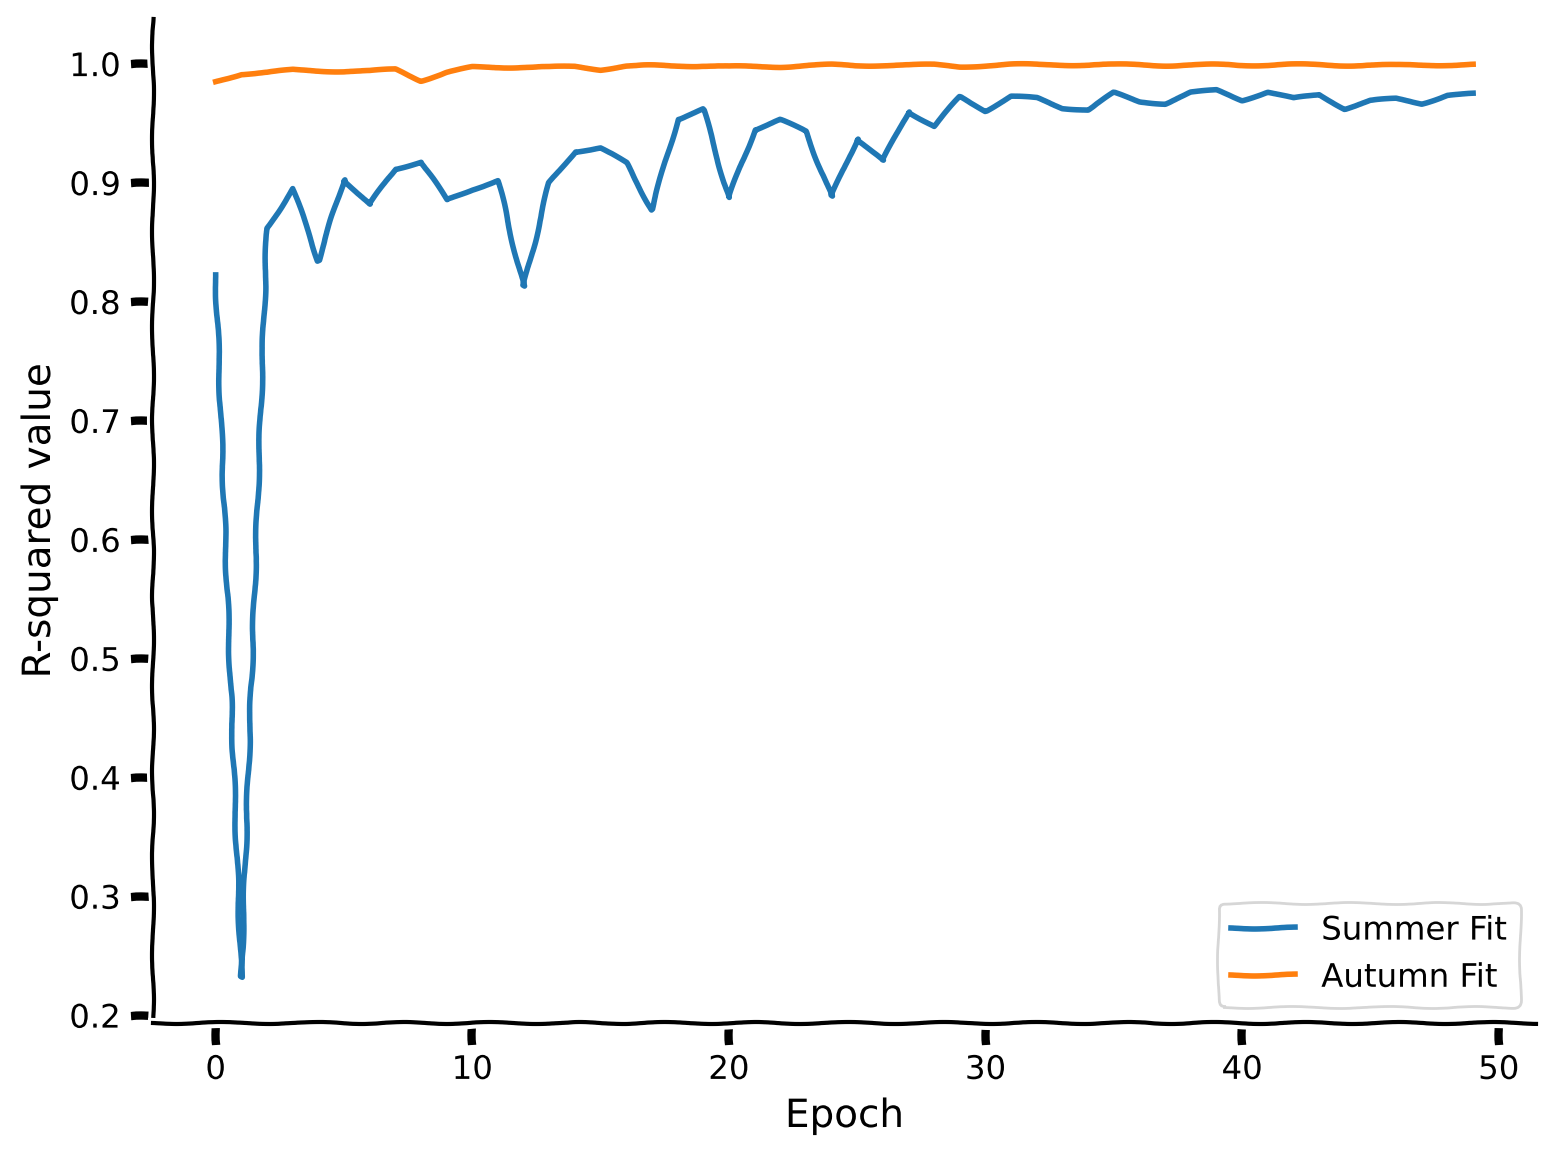

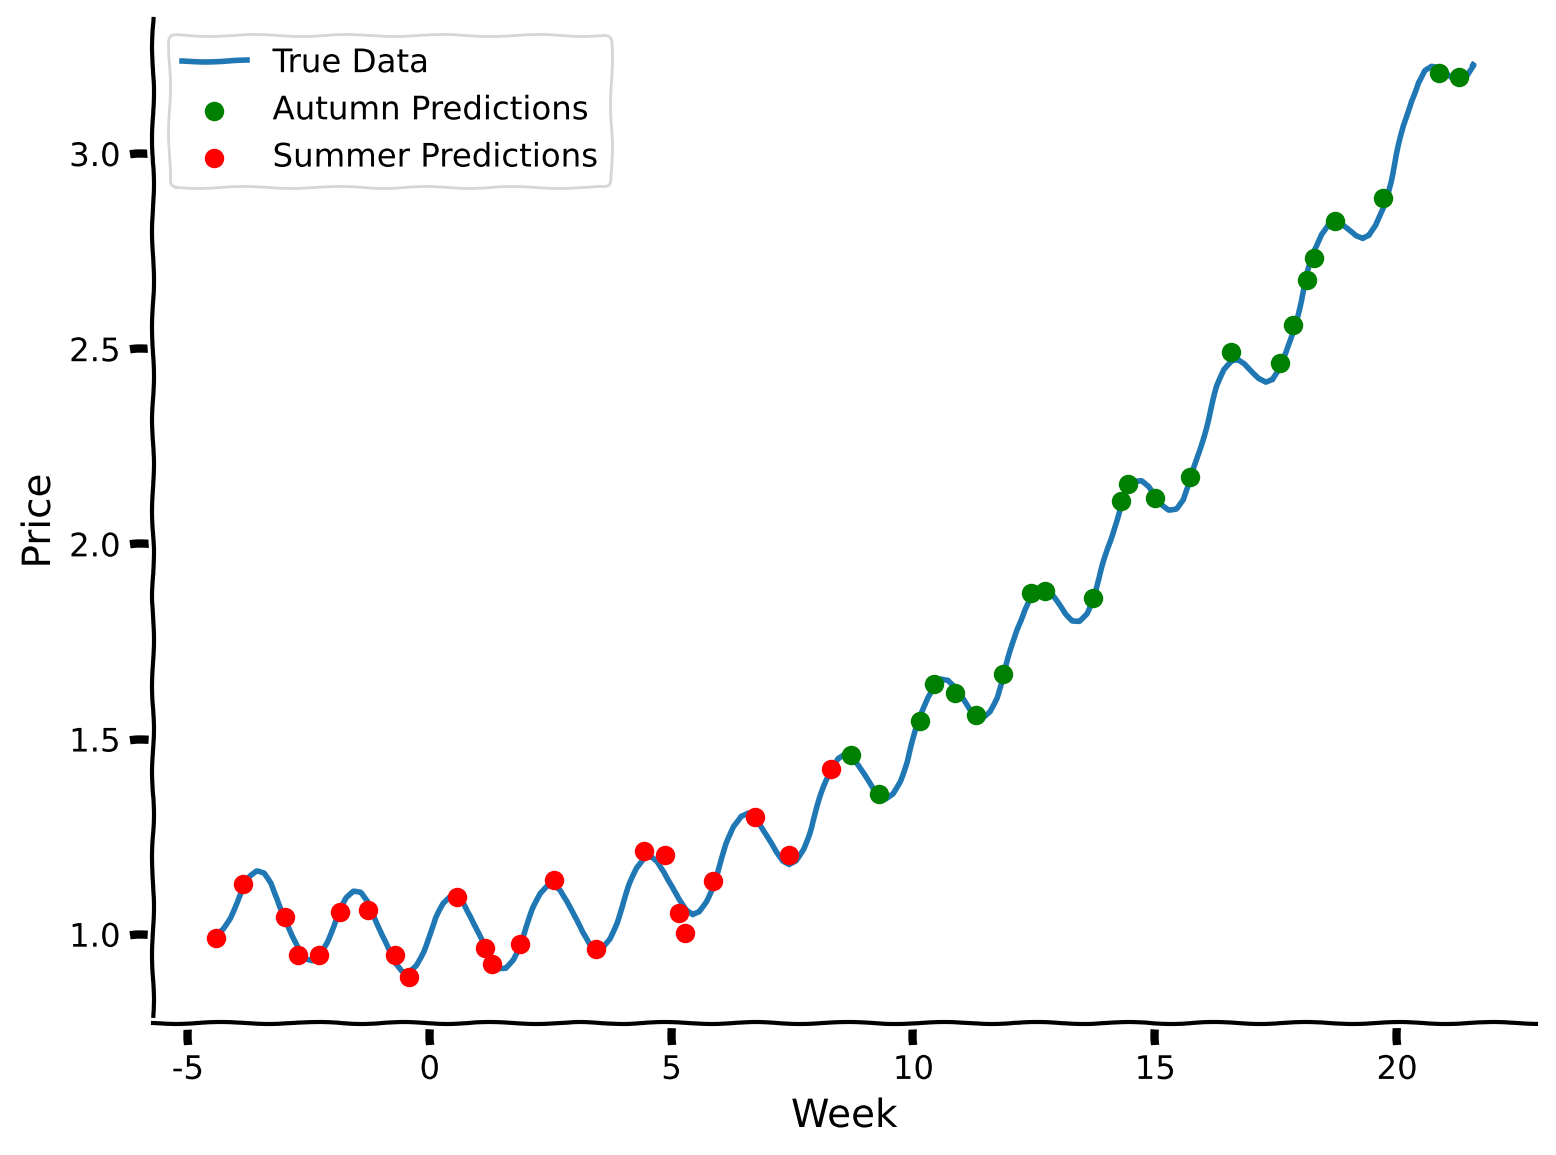

In [13]:
def interspersed_training(K: int, num_epochs: int):
    """
    Perform interspersed training for a multi-layer perceptron (MLP) regression model.

    Inputs:
        - K (int): The number of training examples to sample from each season (summer and autumn) in each epoch.
        - num_epochs (int): The number of training epochs.

    Returns:
        - model (MLPRegressor): The trained MLP regression model.
        - summer_r_squared (list): A list containing the R-squared values for the summer season at each epoch.
        - autumn_r_squared (list): A list containing the R-squared values for the autumn season at each epoch.
    """

    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state = 42, solver = "lbfgs")
    summer_r_squared = []
    autumn_r_squared = []

    for _ in tqdm(range(num_epochs), desc="Training Progress"):

        # Sample random training examples from summer and autumn
        sampled_summer_indices = np.random.choice(np.arange(summer_days_train_norm.shape[0]), size=K, replace=False)
        sampled_autumn_indices = np.random.choice(np.arange(autumn_days_train_norm.shape[0]), size=K, replace=False)


        mixed_days_train = np.expand_dims(np.append(autumn_days_train_norm[sampled_autumn_indices],
                                                    summer_days_train_norm[sampled_summer_indices]), 1)
        ###################################################################
        ## Fill out the following then remove
        # raise NotImplementedError("Student exercise: make price labels for mixed epochs and train")
        ###################################################################
        mixed_prices_train = np.expand_dims(np.append(autumn_prices_train[sampled_autumn_indices],
                                                    summer_prices_train[sampled_summer_indices]), 1)
        model.partial_fit(mixed_days_train,mixed_prices_train )

        summer_r_squared.append(model.score(summer_days_test_norm, summer_prices_test))
        autumn_r_squared.append(model.score(autumn_days_test_norm, autumn_prices_test))

    return model, summer_r_squared, autumn_r_squared

set_seed(42)
num_epochs = 50
K = 30

interspersed_training_model, summer_r_squared, autumn_r_squared = interspersed_training(K, num_epochs)

plot_performance(num_epochs, summer_r_squared, autumn_r_squared)

#predict for test sets
summer_prices_predictions = interspersed_training_model.predict(summer_days_test_norm)
autumn_prices_predictions = interspersed_training_model.predict(autumn_days_test_norm)

plot_summer_autumn_predictions(summer_prices_predictions, autumn_prices_predictions)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial2_Solution_07232036.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial2_Solution_07232036_53.png>

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial2_Solution_07232036_54.png>



### Coding Exercise 2 Discussion

1. Note that the number of epochs is doubled in sequential training mode compared to interspersed mode. Why is this the case?
2. Which training scheduler performed better in this particular example? Why do you think this occurred?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial2_Solution_2ba000ea.py)



---
# Summary

*Estimated timing of tutorial: 25 minutes*

Here is a summary of what we've learned:

1. Simply continuing to train on a new data distribution causes catastrophic forgetting

2. Joint training, wherein different datasets are interspersed to varying degrees, helps fight catastrophic forgetting.

You can explore more advanced methods of continual learning in the following resources:

- [Continual Lifelong Learning with Neural Networks: A Review](https://arxiv.org/pdf/1802.07569)
- [ContinualAI](https://www.continualai.org/)
- [A Comprehensive Survey of Continual Learning: Theory, Method and Application](https://arxiv.org/pdf/2302.00487)
- [Brain-inspired replay for continual learning with artificial neural networks](https://www.nature.com/articles/s41467-020-17866-2)

# The Big Picture

What causes catastrophic forgetting? If we train tasks continually (one after the other) and not in a joint fashion, it implies the overwriting of old knowledge (information) with new knowledge (information). That doesn't seem to happen in biological systems, so is there a lesson we can take from psychology and neuroscience to better handle catastrophic forgetting? Information seems to be distributed across all weights for this ovwerwriting to happen. Large LLM models have developed one solution, the so-called Mixture-of-Experts Model. This is where a routing mechanism decides what sections of a neural network become active for each tasks. Is that a viable solution? These models are gigantic and extremely computationally expensive. We think there is scope to be more brain-like without requiring such vast computational giants.

If you're interested in learning more, the topics we covered today are also often referred to as the **Stability-Plasticity Dilemma**. A search for that term will certainly bring you to many recent advances in exploring this idea.  

But before you do that, let's first prepare ourselves for the next tutorial on Meta-Learning. See you there!